# Building Multimodal Model

In [1]:
cd ..

/notebooks/MultimodalTweetsClassification


In [2]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [4]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [5]:
path = Path('/notebooks/MultimodalTweetsClassification')
# path.ls()

In [6]:
path_img = path/'data_image'

In [7]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [8]:
#reading csv files and doing initial necessary processing
data_human_text_image,test_data_human_text_image = get_dataframe(*get_tsv_data_files('humanitarian_task_tsv_files'),path)

reading data and preprocessing it.....
done!!


In [9]:
print(f"shape of data: {data_human_text_image.shape}\n")
print(f"train set: {data_human_text_image['is_valid'].value_counts()[0]}")
print(f"valid set: {data_human_text_image['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_human_text_image.shape}\n")

shape of data: (7124, 10)

train set: 6126
valid set: 998
shape of test data: (955, 9)



In [10]:
MODEL_CLASSES = {'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)}

In [11]:
model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased'

In [12]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [13]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [14]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)

In [15]:
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [16]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [17]:
# preprocessing and creating text databunch object for data(train and dev split) and test data(test split)
data_clas = get_text_data(data_human_text_image,path,pad_first,pad_idx,processor=transformer_processor)
test_data_clas = get_test_text_data(test_data_human_text_image,path,pad_first,pad_idx,processor=transformer_processor)

# making single databunch object of data and test data
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [18]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = False
# print(config)

In [19]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(pad_idx,transformer_model = transformer_model)

In [20]:
CustomAdamW = partial(AdamW, correct_bias=False)

learn_clas = Learner(data_clas, custom_transformer_model,opt_func = CustomAdamW, 
                  metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [21]:
# learn_clas.model

In [22]:
learn_clas.model.transformer = learn_clas.model.transformer.distilbert
# learn_clas.model

In [23]:
#creating image databunch object for data(train and dev split) and test data(test split)
data_img = get_image_data(data_human_text_image,path,224)
test_data_img = get_test_image_data(test_data_human_text_image,path,224)

# making single databunch object of data and test data
data_img.add_test(test_data_img.x)
data_img.test_ds.y = test_data_img.y

In [24]:
# creating a learner object with image model to use it for concatenation 
arch = models.resnet152
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [25]:
# learn_img.model

In [26]:
learn_img.model[-1] = learn_img.model[-1][:-3]
# learn_img.model

In [27]:
#creating dataset object of ConcatDataset Class
train_ds = ConcatDataset(data_img.train_ds, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(data_img.valid_ds, data_clas.valid_ds.x, data_clas.valid_ds.y)
test_ds = ConcatDataset(data_img.test_ds, data_clas.test_ds.x,data_clas.test_ds.y)

# creating data sampler object
bs = 16
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))
test_sampler = SortSampler(data_clas.test_ds.x, key=lambda t: len(data_clas.test_ds[t][0].data))

In [28]:
# creating dataloader object for databuch
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [29]:
#creating combined image+text databuch object to use it in learner for training 
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [30]:
(x1,x2),y = next(iter(data.test_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([16, 3, 224, 224])
Shape text batch: torch.Size([16, 94])
Shape dependent var: torch.Size([16])


In [31]:
lin_layers = [512+768, 5]
ps = 0.1
model = IntermediateConcatModel(learn_img.model, learn_clas.model, lin_layers, ps,with_transformer=True)

In [32]:
#making layer groupes and creating learner object for training
loss_func = nn.CrossEntropyLoss()

layer_groups = [nn.Sequential(*(flatten_model(learn_clas.model.transformer.embeddings)+
                                flatten_model(learn_clas.model.transformer.transformer.layer[0])+
                                flatten_model(learn_clas.model.transformer.transformer.layer[1])+
                                flatten_model(learn_img.layer_groups[0]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.transformer.layer[2])+
                                flatten_model(learn_clas.model.transformer.transformer.layer[3])+
                                flatten_model(learn_img.layer_groups[1]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.transformer.layer[4])+
                                flatten_model(learn_clas.model.transformer.transformer.layer[5])+
                                flatten_model(learn_img.layer_groups[2]))),
               nn.Sequential(*(
                   flatten_model(model.layers)))]

In [33]:
# model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [34]:
len(learn.layer_groups)

4

In [54]:
learn.freeze()

In [56]:
# training model using discriminative fine-tunnig and gradual unfreezing
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03
Min loss divided by 10: 1.58E-03


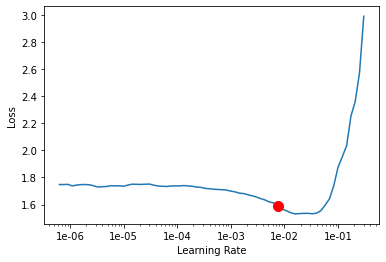

In [57]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.926178,0.823487,0.735471,0.581598,0.739488,0.589105,0.735471,0.581151,0.736256,01:34
1,1.073108,1.021053,0.692385,0.539949,0.714805,0.517184,0.692385,0.505032,0.689779,01:33
2,0.754376,0.747450,0.756513,0.595113,0.753970,0.548224,0.756513,0.566551,0.748839,01:33
3,0.506815,0.716130,0.765531,0.583863,0.766415,0.594511,0.765531,0.585160,0.762177,01:33
4,0.409424,0.711398,0.755511,0.572704,0.757327,0.601856,0.755511,0.584439,0.754873,01:33


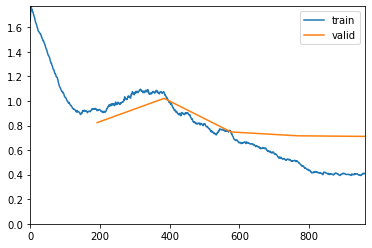

Better model found at epoch 0 with accuracy value: 0.7354709506034851.
Epoch 1: reducing lr to 0.0019009692640269476
Better model found at epoch 2 with accuracy value: 0.7565129995346069.
Better model found at epoch 3 with accuracy value: 0.765531063079834.


In [58]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn.fit_one_cycle(5,slice(1e-2), moms=(0.8, 0.7),wd=1e-1,
                   callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.580530,0.785873,0.762525,0.607876,0.763758,0.605726,0.762525,0.606140,0.762480,01:35
1,0.335753,0.741118,0.773547,0.604827,0.769405,0.580241,0.773547,0.590705,0.768817,01:35


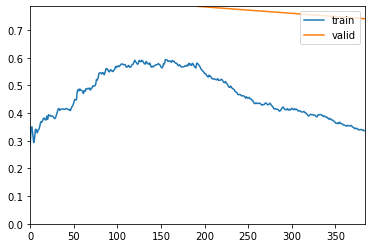

In [59]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.687117,0.713619,0.745491,0.626615,0.744697,0.575920,0.745491,0.593257,0.742596,02:00
1,0.512484,0.753389,0.757515,0.609540,0.760558,0.531772,0.757515,0.561130,0.748554,02:00
2,0.166908,0.694436,0.779559,0.622095,0.781302,0.628824,0.779559,0.624313,0.779572,02:00


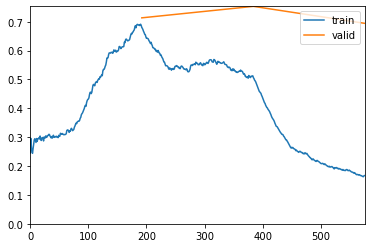

Epoch 1: reducing lr to 0.00018446409268927654


In [60]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


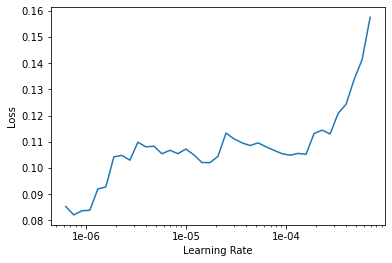

In [61]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.094228,0.705096,0.777555,0.635157,0.776793,0.604563,0.777555,0.618055,0.774911,02:15
1,0.071958,0.715238,0.780561,0.644682,0.777167,0.608791,0.780561,0.624537,0.777505,02:14


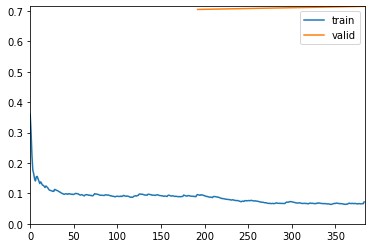

In [62]:
learn.fit_one_cycle(2, slice(5e-5/(2.6**4), 5e-5), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.057722,0.710811,0.789579,0.650280,0.788177,0.618699,0.789579,0.632437,0.786633,02:14
1,0.061864,0.733454,0.786573,0.612309,0.784174,0.605788,0.786573,0.608848,0.785070,02:14
2,0.035592,0.767225,0.779559,0.606446,0.776937,0.598760,0.779559,0.601785,0.777389,02:14
3,0.033194,0.777412,0.778557,0.603908,0.776005,0.598630,0.778557,0.600789,0.776767,02:14


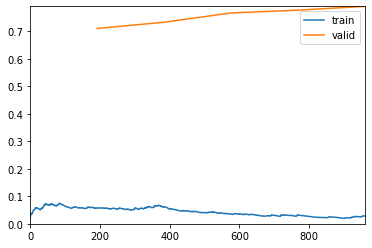

Better model found at epoch 0 with accuracy value: 0.7895791530609131.
Epoch 1: reducing lr to 9.504846320134737e-06
Epoch 2: reducing lr to 6.112620219362892e-06
Epoch 3: reducing lr to 1.8825834605023696e-06
Epoch 4: early stopping


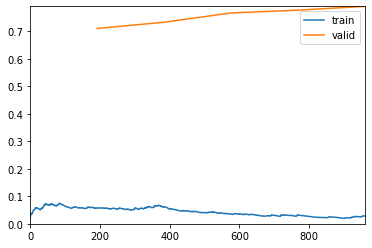

In [63]:
# training all layer's of the model and saving the best one 
learn.fit_one_cycle(5, slice(5e-5/(2.6**4), 5e-5), moms=(0.8, 0.7), wd=1e-1,
                    callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

In [64]:
# making interpretation on dev split
interp = ClassificationInterpretation.from_learner(learn)

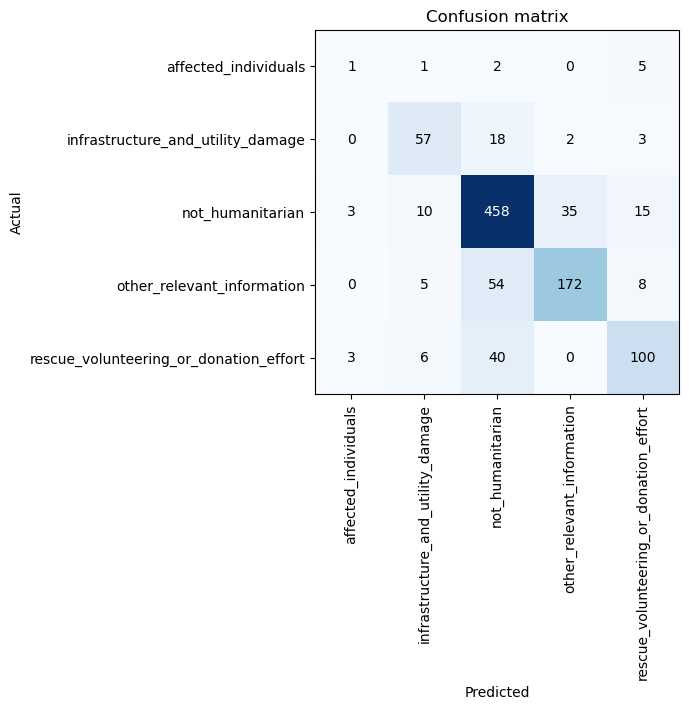

In [65]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=100)

In [66]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.71081114,
 tensor(0.7896),
 tensor(0.6503),
 tensor(0.7882),
 tensor(0.6187),
 tensor(0.7896),
 tensor(0.6324),
 tensor(0.7866)]

In [67]:
#making predictions on validation set to use it for classification report
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.14      0.11      0.12         9
     infrastructure_and_utility_damage       0.72      0.71      0.72        80
                      not_humanitarian       0.80      0.88      0.84       521
            other_relevant_information       0.82      0.72      0.77       239
rescue_volunteering_or_donation_effort       0.76      0.67      0.71       149

                              accuracy                           0.79       998
                             macro avg       0.65      0.62      0.63       998
                          weighted avg       0.79      0.79      0.79       998



In [68]:
learn.validate(data.test_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.6480847,
 tensor(0.7916),
 tensor(0.7475),
 tensor(0.7902),
 tensor(0.6289),
 tensor(0.7916),
 tensor(0.6636),
 tensor(0.7868)]

In [69]:
#making predictions on test set to use it for classification report
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(test_y, test_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.67      0.22      0.33         9
     infrastructure_and_utility_damage       0.75      0.73      0.74        81
                      not_humanitarian       0.79      0.89      0.84       504
            other_relevant_information       0.87      0.76      0.81       235
rescue_volunteering_or_donation_effort       0.66      0.55      0.60       126

                              accuracy                           0.79       955
                             macro avg       0.75      0.63      0.66       955
                          weighted avg       0.79      0.79      0.79       955

